# Obtain American Community Survey Data from api.census.gov
This code demonstrates how to obtain ACS data from the US Census API

For more details on the ACS and Census API see the [ReadMe.md File](ReadMe.md)

## Description of Program
- program:    acg_1av1_ACS #acg short for api.census.gov
- task:       Code to obtain ACS data
- Version:    2026-02-17
- project:    Urban Analytics URSC 645
- funding:	  Texas A&M University Department of Landscape Architecture and Urban Planning
- author:     Nathanael Rosenheim

In [1]:
# Python packages required to read in and Census API data
import requests         # Required for the Census API
import pandas as pd     # For reading, writing and wrangling data
import numpy as np      # For data cleaning
import sys              # For displaying package versions

In [3]:
# Check python and package versions - important for replicating work
print("Python Version    : ", sys.version)
print("pandas version    : ", pd.__version__)
print("numpy version     : ", np.__version__)

Python Version    :  3.12.12 | packaged by conda-forge | (main, Jan 26 2026, 23:38:32) [MSC v.1944 64 bit (AMD64)]
pandas version    :  3.0.1
numpy version     :  2.4.2


In [4]:
program_name = "acg_1av1_ACS"

## Step 1: Obtain Data
This example uses the Census API to get all the block groups for an individual county. (`state:48_county:167`). 

To figure our what variables you would like to get here are some helpful tools:

- [Census Reporter](https://censusreporter.org/profiles/16000US4815976-college-station-tx/) great website to get overviews of any census geography. Each section has infographics and the option to "Show data". The show data function provides the Table ID. Note only has most recent ACS.
- [data.census.gov](https://data.census.gov/table/ACSDT1Y2024.B01001?q=B01001&g=050XX00US48041_160XX00US4815976_310XX00US17780) provides full range of Census data files. Provides API link for data.

Example api Link for data.census.gov:

[https://api.census.gov/data/2024/acs/acs1?get=group(B01001)&ucgid=0100000US,0400000US48,0500000US48041,1600000US4815976,310M700US17780](https://api.census.gov/data/2024/acs/acs1?get=group(B01001)&ucgid=0100000US,0400000US48,0500000US48041,1600000US4815976,310M700US17780)

Link above is for 2024 ACS 1 year Table B01001 with the following geographies:

| Geography | FIPS Code |
|-----------|------|
| United States | 100000US |
| Texas | 0400000US48 |
| Brazos County, Texas | 0500000US48041 |
| College Station, Texas | 1600000US4815976 |
| College Station-Bryan, TX Metro Area | 310M700US17780 |

In [5]:
state    = '48'     # State FIPS Code   
# List of County FIPS Codes within the same state
county = '167'
acs_year = '2022'   # ACS Year
acs_type = '5'      # 5-year or 1-year ACS Single-Year or Multiyear Estimates

# Variables to get
var = 'B19013' 
# B03002 = HISPANIC OR LATINO ORIGIN BY RACE, 
# B19013 = Median Household Income

In [6]:
# Set up hyperlink for Census API
api_hyperlink = (f'https://api.census.gov/data/{acs_year}/acs/acs{acs_type}?get=group({var})' +
                    f'&in=state:{state}+county:{county}&for=block%20group:*')

print("Census API data from: "+ api_hyperlink)

# Obtain Census API JSON Data
api_json = requests.get(api_hyperlink)
# Convert the requested json into pandas dataframe
api_df = pd.DataFrame(columns=api_json.json()[0], data=api_json.json()[1:])

Census API data from: https://api.census.gov/data/2022/acs/acs5?get=group(B19013)&in=state:48+county:167&for=block%20group:*


In [7]:
api_df.head(5)

,B19013_001E,B19013_001EA,B19013_001M,B19013_001MA,GEO_ID,NAME,state,county,tract,block group
0,86840,NaN,33360,NaN,1500000US481677201001,Block Group 1; Census Tract 7201; Galveston Co...,48,167,720100,1
1,97431,NaN,46821,NaN,1500000US481677201002,Block Group 2; Census Tract 7201; Galveston Co...,48,167,720100,2
2,135179,NaN,72377,NaN,1500000US481677201003,Block Group 3; Census Tract 7201; Galveston Co...,48,167,720100,3
3,245658,NaN,26567,NaN,1500000US481677201004,Block Group 4; Census Tract 7201; Galveston Co...,48,167,720100,4
4,177045,NaN,23688,NaN,1500000US481677202001,Block Group 1; Census Tract 7202; Galveston Co...,48,167,720200,1


# Step 2: Data cleaning
In this step we will clean the data file.
Currently the Median Income Data is stored as a string and needs to be converted to a number.

In [8]:
api_df[['GEO_ID','state','county']].describe()

,GEO_ID,state,county
count,276,276,276
unique,276,1,1
top,1500000US481677201001,48,167
freq,1,276,276


In [9]:
### 2.1 Set the variable type
api_df[f"{var}_001E"] = api_df[f"{var}_001E"].astype(int)
api_df[f"{var}_001M"] = api_df[f"{var}_001M"].astype(int)

In [10]:
pd.option_context('float_format', '{:,.0f}'.format)
api_df[[f'{var}_001E', f'{var}_001M']].describe()

,B19013_001E,B19013_001M
count,2.760000e+02,2.760000e+02
mean,-8.928821e+07,-3.217480e+07
std,2.275887e+08,8.008321e+07
min,-6.666667e+08,-3.333333e+08
25%,4.706975e+04,1.335125e+04
50%,8.048800e+04,2.372500e+04
75%,1.141808e+05,4.466975e+04
max,2.500010e+05,1.995990e+05


## Replace Missing Data Codes
Notice that missing data is flagged as -666666666 and -222222222.
The details of these codes can be found in the Notes tab on data.census.gov

See [ReadMe.md File](ReadMe.md) for more details on missing data codes.


In [11]:
api_df.loc[api_df[f"{var}_001E"]==-666666666].head(5)

,B19013_001E,B19013_001EA,B19013_001M,B19013_001MA,GEO_ID,NAME,state,county,tract,block group
20,-666666666,-,-222222222,**,1500000US481677205041,Block Group 1; Census Tract 7205.04; Galveston...,48,167,720504,1
28,-666666666,-,-222222222,**,1500000US481677205071,Block Group 1; Census Tract 7205.07; Galveston...,48,167,720507,1
53,-666666666,-,-222222222,**,1500000US481677207011,Block Group 1; Census Tract 7207.01; Galveston...,48,167,720701,1
55,-666666666,-,-222222222,**,1500000US481677207013,Block Group 3; Census Tract 7207.01; Galveston...,48,167,720701,3
57,-666666666,-,-222222222,**,1500000US481677207022,Block Group 2; Census Tract 7207.02; Galveston...,48,167,720702,2


In [12]:
# in the data frame locate the observations and replace the variable with the new value
api_df.loc[api_df[f"{var}_001E"]==-666666666, f"{var}_001E"] = np.nan
api_df.loc[api_df[f"{var}_001M"]==-222222222, f"{var}_001M"] = np.nan

# Check cleaned variables
api_df[[f'{var}_001E', f'{var}_001M']].describe()

,B19013_001E,B19013_001M
count,239.000000,2.390000e+02
mean,96742.644351,-2.753230e+06
std,50275.173356,3.043184e+07
min,16973.000000,-3.333333e+08
25%,60570.000000,1.819050e+04
50%,88664.000000,2.785400e+04
75%,121817.500000,5.011300e+04
max,250001.000000,1.995990e+05


In [13]:
# Add GEOID for merge with shapefile
api_df['BGGEOID20'] = api_df['state'] + api_df['county'] + api_df['tract'] + api_df['block group']
api_df['BGGEOID20'].describe()

count              276
unique             276
top       481677201001
freq                 1
Name: BGGEOID20, dtype: object

In [14]:
# Add survey year
api_df['ACSyr'] = acs_year
api_df['ACSType'] = acs_type
# reorder and drop columns
api_df_v2 = api_df[['BGGEOID20', 'ACSyr', f'{var}_001E', f'{var}_001M']].copy()
api_df_v2.head(1)

,BGGEOID20,ACSyr,B19013_001E,B19013_001M
0,481677201001,2022,86840.0,33360.0


## Step 3: Explore Data

In [15]:
api_df_v2.describe().T

,count,mean,std,min,25%,50%,75%,max
B19013_001E,239.0,9.674264e+04,5.027517e+04,16973.0,60570.0,88664.0,121817.5,250001.0
B19013_001M,239.0,-2.753230e+06,3.043184e+07,-333333333.0,18190.5,27854.0,50113.0,199599.0


<Axes: >

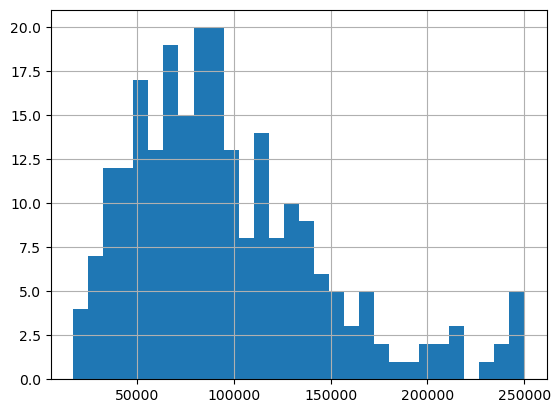

In [16]:
# make a histogram of the median household income variable
api_df_v2[f'{var}_001E'].hist(bins=30)

### Look at metadata for Data Dictionary

In [17]:
data_dictionary_list = []

# Variables that don't have Census API metadata
skip_variables = ['BGGEOID20', 'ACSyr', 'ACSType', 'GEO_ID', 'NAME']

for variable in api_df_v2.columns:
    print(f"Processing {variable}...")
    
    # Skip variables that don't have Census metadata
    if variable in skip_variables:
        print(f"{variable}: Skipping (not a Census variable)")
        data_dictionary_list.append({
            'variable': variable,
            'label': variable,
            'concept': ''
        })
        continue
    
    try:
        # read in json to pandas
        json_url = f'https://api.census.gov/data/{acs_year}/acs/acs{acs_type}/variables/{variable}.json'
        metadata_json = requests.get(json_url, timeout=5).json()
        # Find the variable label 
        census_label_string = str(metadata_json["label"])
        last_exclamation_point_position = census_label_string.rfind("!!")
        if last_exclamation_point_position >= 0:
            last_exclamation_point_position = last_exclamation_point_position + 2
        else:
            last_exclamation_point_position = 0
        label = census_label_string[last_exclamation_point_position:] 

        # Add vintage to label name
        label_addvintage = label + f' {acs_year} {acs_type}-year'

        # Add estimate or Margin of Error to label
        last_letter_of_variable = variable[-1]
        if last_letter_of_variable == 'E':
            label_addvintage_addtype = label_addvintage + ' (Estimate)'
        elif last_letter_of_variable == 'M':
            label_addvintage_addtype = label_addvintage + ' (MOE)'
        else:
            label_addvintage_addtype = label_addvintage
        label = label_addvintage_addtype
        concept = metadata_json.get("concept", "")
    except Exception as e:
        print(f"{variable}: Error - {str(e)}")
        label = variable
        concept = ""

    # Append to data dictionary list
    data_dictionary_list.append({
        'variable': variable,
        'label': label,
        'concept': concept
    })
    
    print(f"{variable}: {label}\n")

# Convert list to DataFrame
data_dictionary = pd.DataFrame(data_dictionary_list)
print("Data dictionary complete!")
data_dictionary

Processing BGGEOID20...
BGGEOID20: Skipping (not a Census variable)
Processing ACSyr...
ACSyr: Skipping (not a Census variable)
Processing B19013_001E...
B19013_001E: Median household income in the past 12 months (in 2022 inflation-adjusted dollars) 2022 5-year (Estimate)

Processing B19013_001M...
B19013_001M: Median household income in the past 12 months (in 2022 inflation-adjusted dollars) 2022 5-year (MOE)

Data dictionary complete!


,variable,label,concept
0,BGGEOID20,BGGEOID20,
1,ACSyr,ACSyr,
2,B19013_001E,Median household income in the past 12 months ...,Median Household Income in the Past 12 Months ...
3,B19013_001M,Median household income in the past 12 months ...,Median Household Income in the Past 12 Months ...


# Save Cleaned Datafile

In [21]:
# Save the data to a csv file
file_suffix = (f'ACS{acs_year}_{acs_type}_{var}_{state}{county}')
file_name = f"{program_name}_{file_suffix}.csv"
api_df_v2.to_csv(file_name, index=False)

In [22]:
# save data dictionary to csv
data_dictionary_file_name = f"{program_name}_{file_suffix}_metadata.csv"
data_dictionary.to_csv(data_dictionary_file_name, index=False)